# Costa Rican Household Poverty Level Prediction 




## Primary Objective
<br>
The target of our analysis would be to predict poverty on a household level as defined in the dataset. Given that dataset is on an individual level in terms of the datapoints, however we will only include the head of the household to stick with our plan of conducting the analysis on a household basis. The following would be the target variable values: 

1 = extreme poverty <br>
2 = moderate poverty <br>
3 = vulnerable households <br> 
4 = non vulnerable households <br>
<br>

## Special Features 
<br>
Out of the 143 features, following features will be treated little differently in our analysis:
<br>
*Id*: a unique identifier for each individual, this should not be a feature that we use!<br>
<br>
*idhogar*: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.<br>
<br>
*parentesco1*: indicates if this person is the head of the household.<br>
<br>
*Target*: the label, which should be equal for all members in a household <br>
<br>


## Scoring Metric
<br>
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the Macro F1 Score.
<br>

## Secondary Objective
<br>
1. Feature Engineering <br>
2. Select a model by comparison <br>
3. Optimise the choice for the model <br>
4. Understand the outputs of the model <br>
5. Draw insights and breakdown the analysis and prediction <br>
<br>

## Data Cleansing 
<br>

Let's first go through our dataset and look for errors and missing values and see how we can fix it in this section.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

test['Target'] = np.nan
data = train.append(test, ignore_index = True)

In [3]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

In [4]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16,NaN
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681,NaN
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681,NaN
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481,NaN
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324,NaN


In [5]:
unique_values = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 85 households where the family members do not all have the same target.


In [6]:
train[train['idhogar'] == different_households.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


As described in the initial background, we concluded that we would analyse the head of each household to predict which poverty level the household belongs in (i.e. parentesco = 1). So here members of the same households would belong to the same target variables which is 3 in our case.

### Families without a head of the household

Now let's check the families that don't have a head in our dataset

In [7]:
check_leader = train.groupby('idhogar')['parentesco1'].sum()

#Check for head
no_head = train.loc[train['idhogar'].isin(check_leader[check_leader == 0].index), :]
print('There are {} households without a head.'.format(no_head['idhogar'].nunique()))

There are 15 households without a head.


And check for households with no heads but have different labels.

In [8]:
no_head_equal = no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(no_head_equal == False)))

0 Households with no head have different labels.


Meaning that there is no household which has no head and the family members have different labels. 

### Applying Correct Labels

So given that we identified households which do not have a head however their family members have the same label. SO let's fix it by making sure that every family member in the same family has a common target variable.  

In [9]:
for each_household in different_households.index:
    
    #find the correct label
    true_target = int(train[(train['idhogar'] == each_household) & (train['parentesco1'] == 1.0)]['Target'])
    
    #assign the correct label for each member
    train.loc[train['idhogar'] == each_household, 'Target'] = true_target

unique_values = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 0 households where the family members do not all have the same target.


### Finding Feaures with Missing Values and filling them up

Now we need to carefully go through each variable and see how we can replace the missing values with the values we want to fill.

In [10]:
missing_variables = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})
missing_variables['percent'] = missing_variables['total']/len(data)
missing_variables.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


Let's start with fillinf missing values in v2a1 which is essentially the Number of Tablets in a households

In [11]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Now all the families that do not own a tablet have a NaN as value. So we can assign this NaN as 0 instead!

In [12]:
data['v18q1'] = data['v18q1'].fillna(0)

Second, we got v2a1 which is Monthly Rent Payment. We have following categorical variable values:

tipovivi1, =1 own and fully paid house <br>
tipovivi2, "=1 own,  paying in installments" <br>
tipovivi3, =1 rented <br>
tipovivi4, =1 precarious <br>
tipovivi5, "=1 other(assigned,  borrowed)" <br>
<br>

So now for the households that owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [13]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

Now we can move to the next column which is **rez_esc**(years behind in school).<br>
<br>
So it maybe possible that certain datapoints with null value in this column could have the case of none of the family members having any schooling at all. Let's see what are the ages of the family members for which we have null values. 



In [14]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

We can learn that this variable is only defined for individuals between 7 and 19. Anyone older or younger might not have any years of schooling so this can be set to zero. For the rest we shall add a boolean flag.

In [15]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

#Setting the maximum value to 5
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need _all_ of the information summarized for each household. This means grouping the individuals in a house (`groupby`) and performing an aggregation (`agg`) of the individual variables. 

## Column Definitions

Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time.There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description.

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.


### Define Variable Categories

There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category.

In [16]:
id_ = ['Id', 'idhogar', 'Target']

In [17]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [18]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [19]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any. 

In [20]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


#### Squared Variables

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at `SQBage` vs `age`.

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


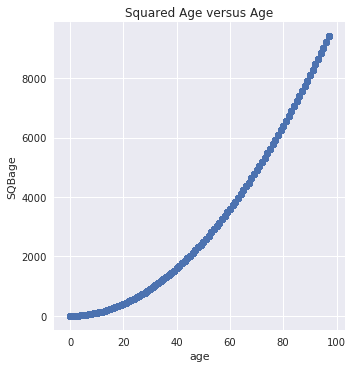

In [21]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

These variables are highly correlated, and we don't need to keep both in our data.

In [22]:
# Remove squared variables
data = data.drop(axis=1,labels = sqr_)
data.shape

(33413, 136)

## Id Variables

These are pretty simple: they will be kept as is in the data since we need them for identification.

## Household Level Variables

First let's subset to the heads of household and then to the household level variables.

In [23]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data. 

### Redundant Household Variables

Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [24]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These show one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [25]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


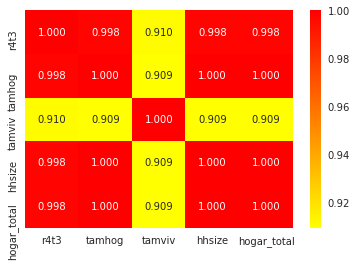

In [26]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

There are several variables here having to do with the size of the house:

* r4t3, Total persons in the household
* tamhog, size of the household
* tamviv, number of persons living in the household
* hhsize, household size
* hogar_total, # of total individuals in the household

These variables are all highly correlated with one another. In fact, `hhsize` has a perfect correlation with `tamhog` and `hogar_total`. We will remove these two variables because the information is redundant. We can also remove `r4t3` because it has a near perfect correlation with `hhsize`.

`tamviv` is not necessarily the same as `hhsize` because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.

In [27]:
heads = heads.drop(axis= 1, labels = ['tamhog', 'hogar_total', 'r4t3'])

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


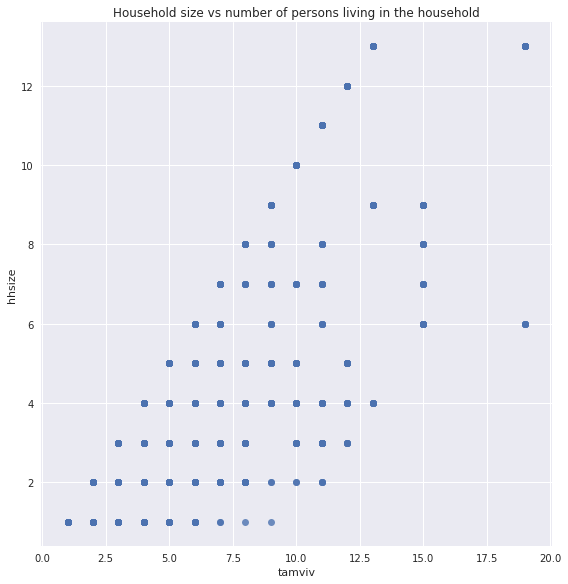

In [28]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: __the difference between these two measurements!__

Let's make this new feature.

In [29]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at `coopele`

In [30]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (`noelec`) or get it from a private plant (`planpri`). 

#### Creating Ordinal Variable

I'm going to compress these four variables into one by creating an ordinal variable. We will try to map the description based on the data description given to us in the problem: 

    0: No electricity
    1: Electricity from cooperative
    2: Electricity from CNFL, ICA, ESPH/JASEC
    3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a `nan` (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [31]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers. 

The final redundant column is `area2`. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [32]:
heads = heads.drop(axis=1, labels = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

### Creating Ordinal Variables

For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: `bad < regular < good`. To do this, we can simply find whichever column is non-zero for each household using `np.argmax`. 

Once we have created the ordinal variable, we are able to drop the original variables.

In [33]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])

In [34]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(axis=1, labels = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

In [35]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']


This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [36]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a `warning` about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [37]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

We can keep using our `plot_categoricals` function to visualize these relationships, but `seaborn` also has a number of plotting options that can work with categoricals. One is the `violinplot` which shows the distribution of a variable on the y axis with the width of each plot showing the number of observations in that category. 

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


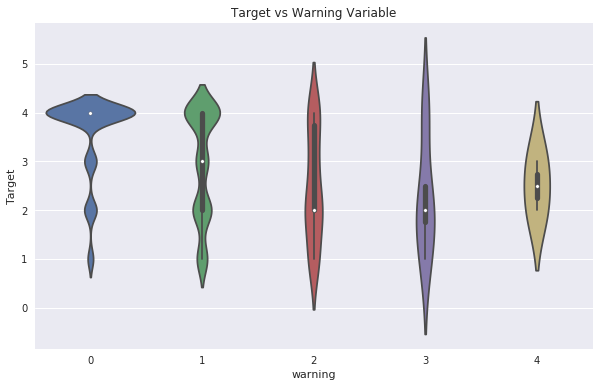

In [38]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a `bonus` where a family gets a point for having a refrigerator, computer, tablet, or television.

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


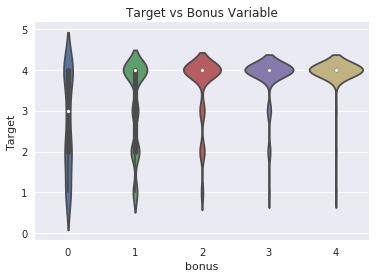

In [39]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

## Per Capita Features

Additional features we can make calculate the number of certain measurements for each person in the household.

In [40]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

### Measuring Relationships

There are many ways for measuring relationships between two variables. Here we will examine two of these:

1. The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables
2. The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables

The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.

In [41]:
from scipy.stats import spearmanr

In [42]:
x = np.array(range(100))
y = x ** 2

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationshisp in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

In [43]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

In most cases, the values are very similar. 

In [44]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

First, we'll calculate the Pearson correlation of every variable with the Target.

In [45]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables:
              feature     pcorr
94  phones-per-capita  0.299026
95              floor  0.307605
96   walls+roof+floor  0.332446
97           meaneduc  0.333652
98             Target  1.000000


For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the `warning` increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The `hogar_nin` is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed.

On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is `meaneduc`, the average education level of the adults in the household. We don't necessarily know which causes which, but we do know these tend to move in the same direction.

The general guidelines for correlation values are below, but these will change depending on who you ask ([source](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) for these):

*  .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
*  .80-1.0 “very strong”

What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

Now we can move on to the Spearman correlation. 

In [46]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a `pvalue` indicating the significance level of the relationship. Any `pvalue` less than 0.05 is genearally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction. 

In [47]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
        feature        pvalue     scorr
94      warning  4.682829e-66 -0.307326
82    hogar_nin  5.567218e-39 -0.236225
77         r4t1  1.112230e-33 -0.219226
49        eviv1  2.952571e-33 -0.217803
8   pisocemento  8.270816e-31 -0.209387

Most positive Spearman correlations:
              feature        pvalue     scorr
23          cielorazo  2.611808e-63  0.300996
92              floor  4.466091e-67  0.309638
96  phones-per-capita  4.760104e-80  0.337377
93   walls+roof+floor  9.539346e-81  0.338791
0              Target  0.000000e+00  1.000000


For the most part, the two methods of calculating correlations are in agreement. Just out of curiousity, we can look for the values that are furthest apart.

In [48]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,pvalue,scorr,diff
75,rooms-per-capita,0.152185,6.521453e-35,0.223303,-0.071119
83,v18q1,0.197493,1.282664e-41,0.244200,-0.046708
85,tablets-per-capita,0.204638,3.951568e-43,0.248642,-0.044004
2,r4t1,-0.260917,1.112230e-33,-0.219226,-0.041691
94,phones-per-capita,0.299026,4.760104e-80,0.337377,-0.038351


In [49]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,pvalue,scorr,diff
32,sanitario3,-0.062316,1.295924e-04,-0.070135,0.007819
64,r4t2,0.036476,1.190145e-01,0.028597,0.007879
70,refrig,0.119607,1.764294e-09,0.110084,0.009523
56,techozinc,0.014357,8.528369e-01,0.003404,0.010954
48,hogar_mayor,-0.025173,2.290994e-02,-0.041722,0.016549


The largest discrepancy in the correlations is `dependency`. We can make a scatterplot of the `Target` versus the `dependency` to visualize the relationship. We'll add a little jitter to the plot because these are both discrete variables.

It's hard to see the relationship, but it's slightly negative: as the `dependency` increases, the value of the `Target` decreases. This makes sense: the `dependency` is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members. 

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


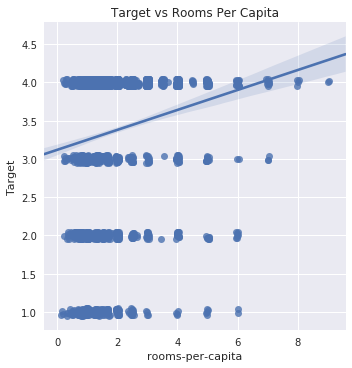

In [50]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

#### Correlation Heatmap 

One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 7 variables and show the correlations between themselves and with the target. 

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


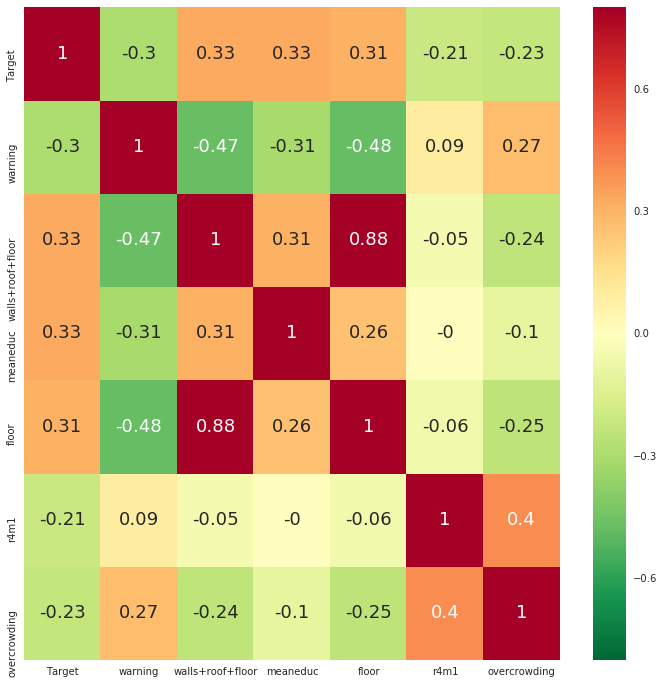

In [51]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

This plot shows us that there are a number of variables that have a weak correlation with the `Target`. There are also high correlations between some variables (such as `floor` and `walls+roof+floor`) which could pose an issue because of collinearity. 

### Features Plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

We'll leave the feature engineering of the household variables for now. Later, we can come back to this step if we are not pleased with the model performance.

In [52]:
household_feats = list(heads.columns)

# Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering). 

In [53]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.

In [54]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

This is simply the opposite of male! We can remove the male flag.

In [55]:
ind = ind.drop(axis = 1, labels = 'male')

### Creating Ordinal Variables

Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the `instlevel_` variables which indicate the amount of education an individual has from `instlevel1`: no level of education to `instlevel9`: postgraduate education. 

To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.

In [56]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [57]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level. 

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


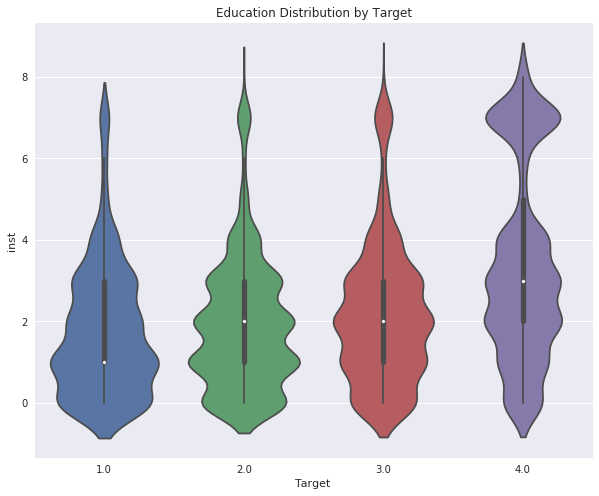

In [58]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [59]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Feature Construction

We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


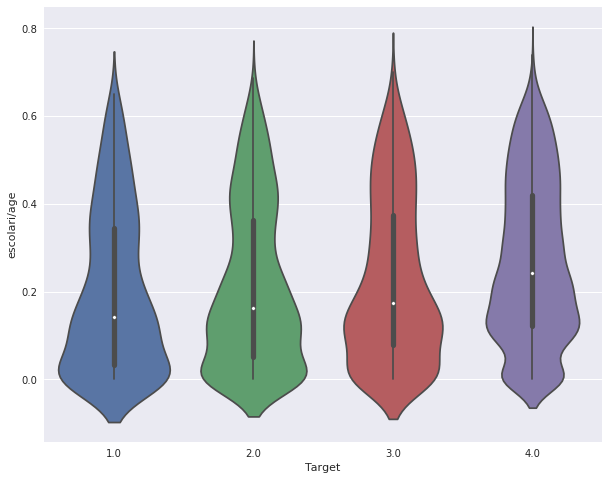

In [60]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

We can also take our new variable, `inst`, and divide this by the age. The final variable we'll name `tech`: this represents the combination of tablet and mobile phones.

In [61]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to `groupby` the family id `idhogar` and then `agg` the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves `range_`. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.

In [62]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(axis = 1, labels = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

/home/krohak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  


v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

With just that one line, we go from 30 features to 180. Next we can rename the columns to make it easier to keep track.

In [63]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        lol = c  + "-" + stat 
        new_col.append(c+"-"+stat)
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-missing-min,rez_esc-missing-max,rez_esc-missing-sum,rez_esc-missing-count,rez_esc-missing-std,rez_esc-missing-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,False,False,0.0,3,0.0,False,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,False,False,0.0,2,0.0,False,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,False,True,1.0,4,0.5,True,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0

In [64]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection 

As a first round of feature selection, we can remove one out of every pair of variables with a correlation greater than 0.95. 

In [65]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print("There are", {len(to_drop)},  "correlated columns to remove.")

There are {115} correlated columns to remove.


We'll drop the columns and then merge with the `heads` data to create a final dataframe.

In [66]:
ind_agg = ind_agg.drop(labels = to_drop, axis=1)
ind_feats = list(ind_agg.columns)
# Merge on the household id
final = heads.join(ind_agg, on='idhogar', how = 'left')

#print("Final features shape: ", final.shape)

In [67]:
ind_feats[:5]

['v18q-min', 'v18q-sum', 'v18q-count', 'v18q-std', 'v18q-range_']

In [68]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [final]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-missing-min,rez_esc-missing-max,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,False,False,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,False,False,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,False,False,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
5,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,False,False,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
8,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,False,False,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.16894

In [69]:
corrs = final.corr()['Target']
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [70]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

In [71]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [72]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

In [73]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


## Machine Learning Modelling



Now that our feature engineering is done, we will move on with doing the actual modelling to see what treasures our data is hiding.<br>
<br>
So let's import the required libraries to conduct our modelling.

In [74]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [75]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(axis=1, labels = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(axis=1,labels = ['Id', 'idhogar', 'Target'])
train_set.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,...,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-missing-min,rez_esc-missing-max,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,False,False,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,False,False,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,False,False,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,False,False,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,False,False,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


So inorder to make sure that scaling and input of missing values happens in one step, we will make a pipeline which will be fit on the training data and will be used to transform the training data and testing data.

In [76]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

Let's run a simple Random Forest Classifier Model and see the output.

In [77]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print("10 Fold Cross Validation F1 Score =", {round(cv_score.mean(), 4)}, "with std =", {round(cv_score.std(), 4)})

10 Fold Cross Validation F1 Score = {0.35249999999999998} with std = {0.051799999999999999}


We can clearly see how bad our score is, however this serves as a baseline for our future analysis and we know that Random Forest is really bad to use for our use case.

### Gauge the importance of different features
<br>

It would be quite convienient for our analysis to rank the features that we would be using for our analysis considering how many are being used. In order to do so we will first try and fit our model.

In [78]:
model.fit(train_set, train_labels)

feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000504
1,hacapo,0.000340
2,v14a,0.000419
3,refrig,0.001853
4,paredblolad,0.006212


We can even use a graphing method to find a correlation between the features and their importance. We will make use of a plotting function which will allows us to visualize it. 

In [79]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title("Most Important Features", size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

/home/krohak/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


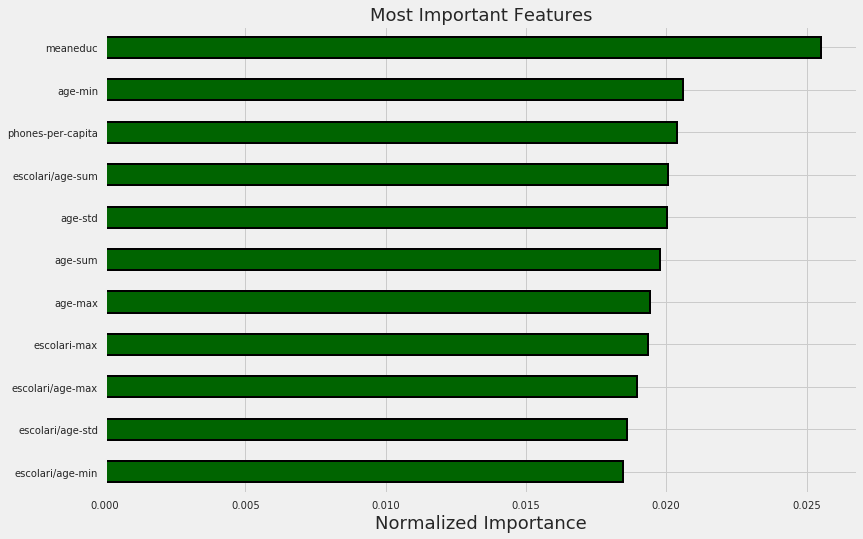

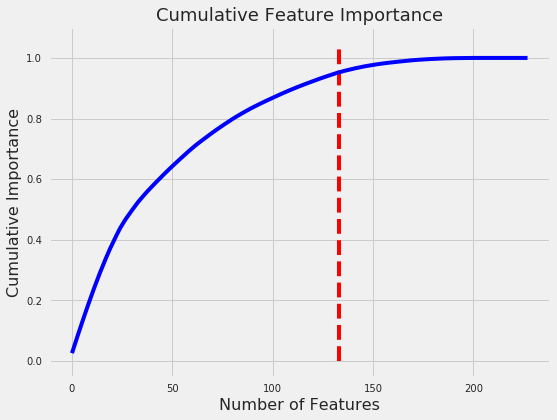

133 features required for 95% of cumulative importance.


In [80]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

As inferenced from the exploratory data analysis, the average amount of education is the most important variable followed by the maximum education of anyone in the household. 

# Model Selection

Most people eventually settle on the __gradient boosting machine__ and we will try that out, but for now we'll take a look at some of the other options.  

What we want to do is write a function that can evaluate a model. In addition to the Random Forest Classifier, we'll try eight other models. 

In [81]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [82]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [83]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.28375 with std: 0.0445


In [84]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.17662 with std: 0.03744


In [85]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.30956 with std: 0.0541


In [86]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.31918 with std: 0.05827


In [87]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27593 with std: 0.03881


In [88]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.35547 with std: 0.03272

KNN with 10 neighbors

10 Fold CV Score: 0.3236 with std: 0.03304

KNN with 20 neighbors

10 Fold CV Score: 0.31346 with std: 0.05282


In [89]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.33192 with std: 0.0356


## Comparing Model Performance

With the modeling results in a dataframe, we can plot them to see which model does the best.

In [90]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.35247 with std: 0.05176


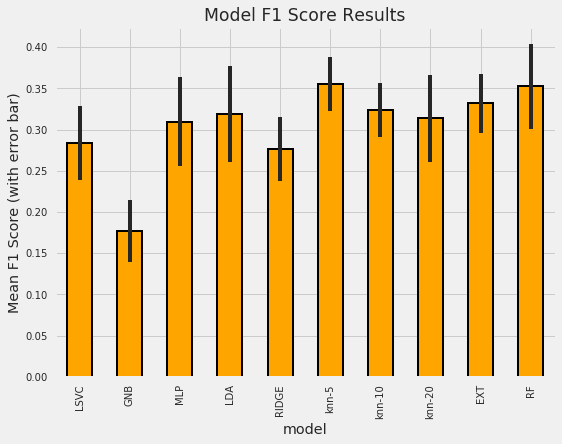

In [91]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

The most likely candidate seems to be the Random Forest because it does best right out of the box.  

Hyperparameter performance does improve the performance of machine learning models, but in most cases the accuracy gain is less than 10% so the worst model is probably not suddenly going to become the best model through tuning. 

# Feature Selection

We'll first remove any columns with greater than 0.95 correlation (we already did some of this during feature engineering). 

In [92]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [93]:
train_set = train_set.drop(axis=1, labels = to_drop)
train_set.shape

(2973, 224)

In [94]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

### Recursive Feature Elimination with Random Forest

The `RFECV` in Sklearn stands for Recursive Feature Elimination with Cross Validation. The selector operates using a model with feature importances in an iterative manner. At each iteration, it removes either a fraction of features or a set number of features. The iterations continue until the cross validation score no longer improves. 

To create the `selector` object, we pass in the the model, the number of features to remove at each iteration, the cross validation folds, our custom scorer, and any other parameters to guide the selection.

In [95]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

In [96]:
selector.fit(train_set, train_labels)

RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
   n_jobs=-1, scoring=make_scorer(f1_score, average=macro), step=1,
   verbose=0)

177

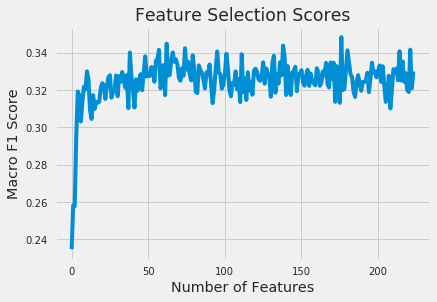

In [97]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

In [98]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
0,hacdor,1
126,estadocivil6-max,1
127,estadocivil7-min,1
128,estadocivil7-max,1
129,estadocivil7-sum,1
130,estadocivil7-std,1
131,parentesco1-min,1
133,parentesco1-std,1
135,parentesco2-max,1
136,parentesco2-std,1


In [99]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [100]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [101]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.33537 with std: 0.04707


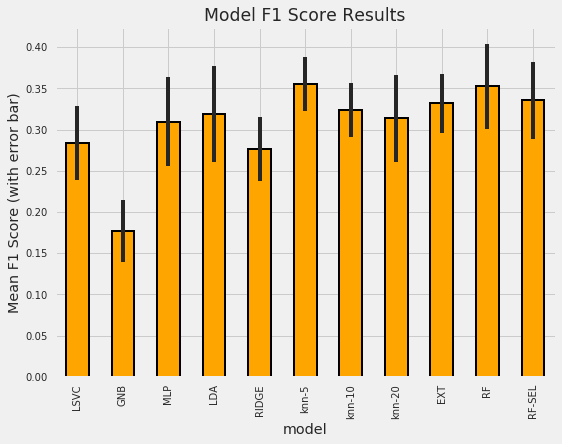

In [102]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

# Gradient Boosting Machine

After using the Random Forest and getting decent scores, it's time to step up and use the gradient boosting machine. If you spend any time on Kaggle, you'll notice that the Gradient Boosting Machine (GBM) wins a high percentage of competitions where the data is structured (in tables) and the datasets are not that large (less than a million observations). 

I won't go too much into the details here, but instead will focus on the implementation. We'll use the GBM in LightGBM, although there are also options in Scikit-Learn, XGBOOST, and CatBoost. The first set of hyperparameters we'll use were based on those I've found have worked well for other problems.

### Choosing Number of Estimators with Early Stopping

To choose the number of estimators (the number of decision trees in the ensemble, called `n_estimators` or `num_boost_rounds`), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [103]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Light Gradient Boosting Machine Implementation

The function below implements training the gradient boosting machine with Stratified Kfold cross validation and early stopping to prevent overfitting to the training data (although this can still occur). The function performs training with cross validation and records the predictions in probability for each fold. 

Choosing hyperparameters for the Gradient Boosting Machine can be tough and generally is done through model optimization.

We set the `n_estimators` to 10000 but we won't actually reach this number because we are using early stopping which will quit training estimators when the cross validation metric does not improve for `early_stopping_rounds`. 

In [104]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

### Cross Validation with Early Stopping Notes

Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. Overall, __early stopping with cross validation__ is the best method to select the number of estimators in the Gradient Boosting Machine and should be our default technique when we desig an implementation.

In [106]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [107]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.39817, Estimators Trained: 100'

'Fold 2, Validation Score: 0.41235, Estimators Trained: 1'

'Fold 3, Validation Score: 0.39787, Estimators Trained: 20'

'Fold 4, Validation Score: 0.42176, Estimators Trained: 207'

'Fold 5, Validation Score: 0.41574, Estimators Trained: 131'

'5 cross validation score: 0.40918 with std: 0.0096.'

The power of the Gradient Boosting Machine can be seen here! The cross validation score blows away anything we've done previously. 

Let's take a look at the predictions to understand what is going on with the predictions in each fold.

In [108]:
predictions.head()

,1,2,3,4,idhogar,fold,Target,confidence
0,0.180820,0.183474,0.178743,0.456964,72958b30c,1,4,0.456964
1,0.197089,0.176936,0.177390,0.448585,5b598fbc9,1,4,0.448585
2,0.198796,0.233413,0.216452,0.351340,1e2fc704e,1,4,0.351340
3,0.204914,0.181540,0.186071,0.427476,8ee7365a8,1,4,0.427476
4,0.179073,0.194346,0.183373,0.443208,ff69a6fc8,1,4,0.443208


For each fold, the 1, 2, 3, 4 columns represent the probability for each Target. The Target is the maximum of these with the confidence the probability. We have the predictions for all 5 folds, so we can plot the confidence in each Target for the different folds.

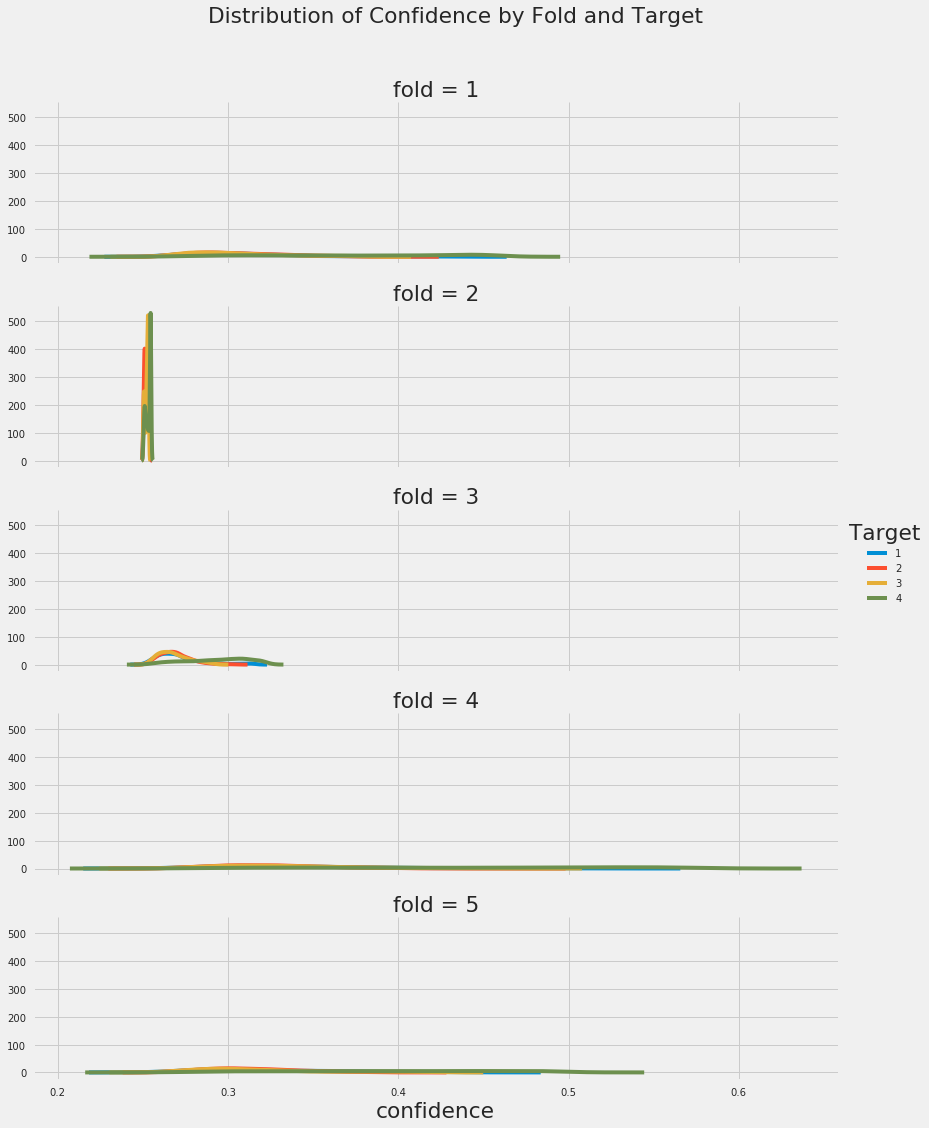

In [109]:
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', size = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

What we see here is that the confidence for each class if relatively low. It does appear that the model has greater confidence in Target=4 predictions which makes sense because of the class imbalance and the high prevalence of this label.

Another way to look at the information is as a violinplot. This shows the same information, with the number of observations related to the width of the plot.

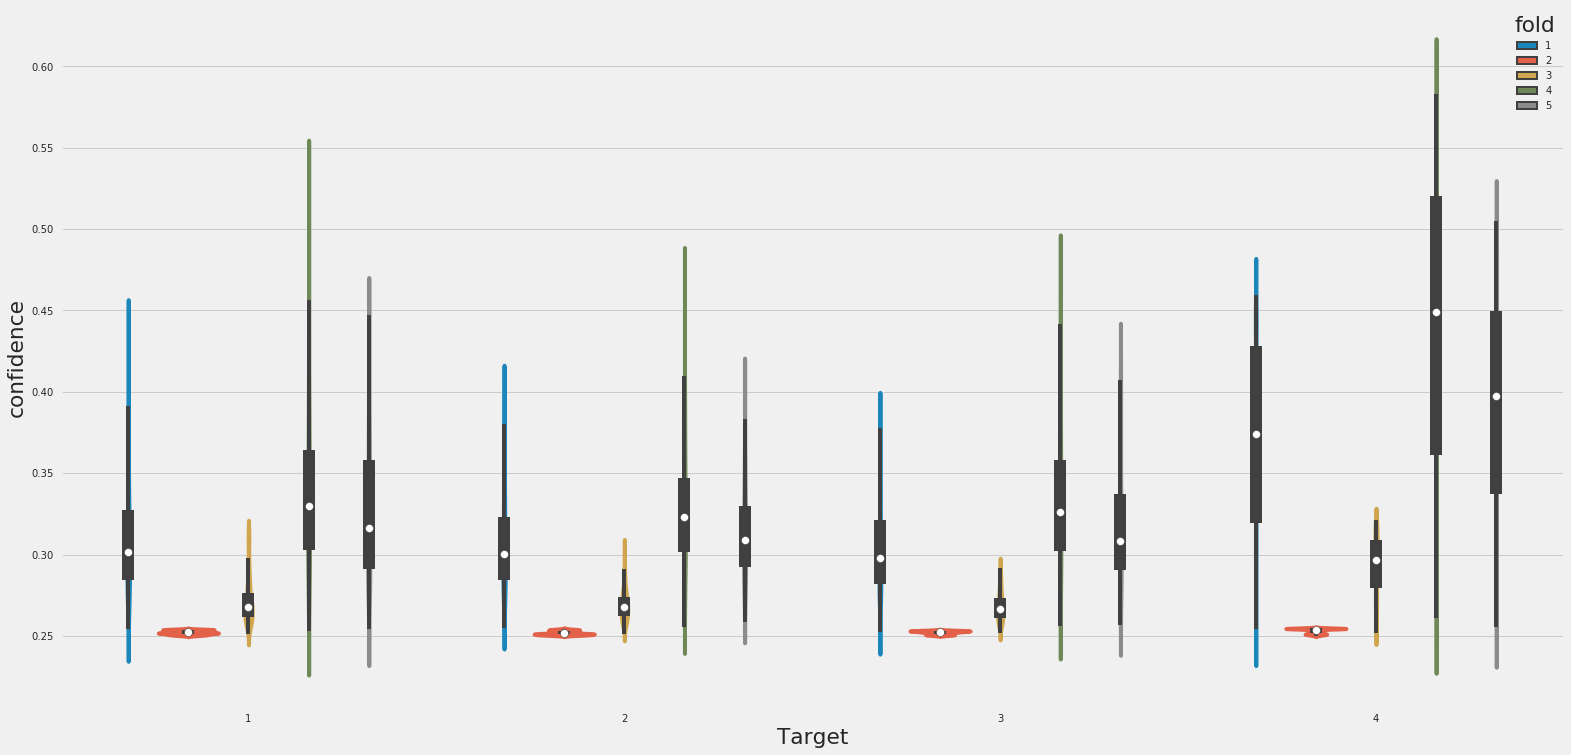

In [110]:
plt.figure(figsize = (24, 12))
sns.violinplot(x = 'Target', y = 'confidence', hue = 'fold', data = predictions);

When we actually make predictions for each household, we average the predictions from each of the folds. Therefore, we are essentially using multiple models since each one is trained on a slightly different fold of the data. The gradient boosting machine is already an ensemble machine learning model, and now we are using it almost as a meta-ensemble by averaging predictions from several gbms.

This process is shown in the code below.

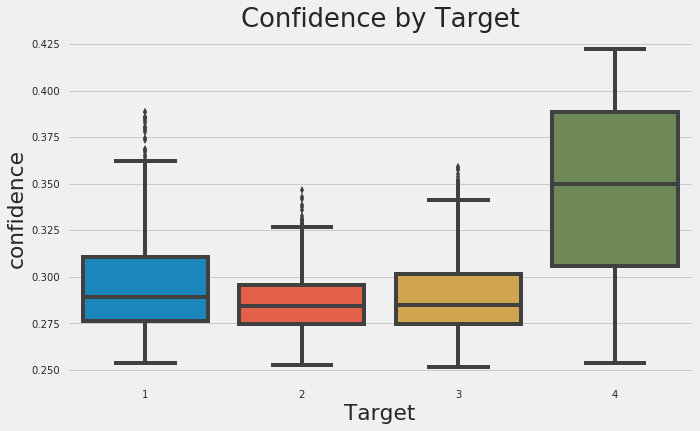

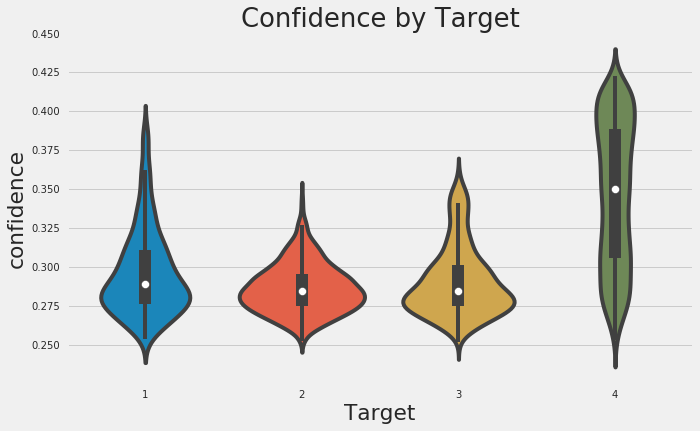

In [112]:
# Average the predictions over folds
predictions = predictions.groupby('idhogar', as_index = False).mean()

# Find the class and associated probability
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
predictions = predictions.drop(axis=1, labels = ['fold'])

# Plot the confidence by each target
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

# Model Optimization

Model optimization is the process of extracting the best performance from a machine learning model by tuning the hyperparameters through cross-validation. This is necessary because the best model hyperparameters are different for every dataset. 

In this notebook, we won't get too far into model tuning, but there are multiple options:

1. Manual
2. Grid Search
3. Random Search
4. Automated Optimization

We will stick to 4. because it is generally the most efficient method and can easily be implemented in a number of libraries, including Hyperopt, which uses a modified version of Bayesian Optimization with the Tree Parzen Estimator. 

# Model Tuning with Hyperopt

Bayesian optimization requires 4 parts:

1. Objective function: what we want to maximize (or minimize)
2. Domain space: region over which to search 
3. Algorithm for choosing next hyperparameters: uses past results to suggest next values
4. Results history: saves the past results

I've written previously about using Hyperopt, so here we'll stick to the implementation. 

In [1]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

ModuleNotFoundError: No module named 'hyperopt'

In [118]:
import csv
import ast
from timeit import default_timer as timer

### 1. Objective Function

This takes in the model hyperparameters and returns the associated validation score. Hyperopt needs a score to minimize, so we return 1 - Macro F1 score. 

In [ ]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']
    
    # Subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type
    
    # Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

### 2. Search Space

The domain is the entire range of values over which we want to search. The only difficult part is the `subsample` ratio which must be set to 1.0 if the `boosting_type="goss"`. Feel free to play around with the values here.

In [ ]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

In [ ]:
sample(space)

### 3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Improvement (EI) of the surrogate model.

In [ ]:
algo = tpe.suggest

### 4. Results History

We'll use two different methods for recording results:

1. Trials object: stores everything returned from the objective function
2. Write to a csv file on every iteration

I like using multiple methods for tracking progress because it means redundancy. One way may fail, but hopefully both will not! The csv file can be used to monitor the method while it is running and the Trials object can be saved and then reloaded to resume optimization.

In [ ]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [ ]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

To resume training, we can pass in the same trials object and increase the max number of iterations. For later use, the trials can be saved as json.

In [ ]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))

## Using Optimized Model

Once the optimization procedure has finished, we can use the best results for modeling.

In [ ]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending = True).reset_index()
results.head()

In [ ]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results);
plt.title("Optimization Scores");
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)));

In [ ]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds = 10, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, 
                                             nfolds = 10, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [ ]:
model_results.head()

In [ ]:
submission.to_csv('gbm_opt_10fold_selected.csv', index = False)

At this point, to improve our performance, we can continue with the optimization, try more feature engineering, stack or ensemble additional models, or look at more experimental methods such as dimension reduction or oversampling. However, the scores we are getting are fairly good and I'm going to move on to a crucial part of machine learning: investigating the predictions to see where our model is wrong. 

While Kaggle is great for presenting realistic datasets, the methods needed to get to the very top of the leaderboard are not generally used in the real-world. Past some level of performance, accuracy takes a back seat to interpretability. People want to know why a model makes the predictions it does, much as they would want a human to be able to explain her decisions. We could work on squeezing some more performance from our model, but right now, our energy is better spent investigating our model. 

In [ ]:
_ = plot_feature_importances(gbm_fi)

# Investigate Predictions

As a first attempt at looking into our model, we can visualize the distribution of predicted labels on the test data. We would expect these to show the same distribution as on the training data. Since we are concerned with household predictions, we'll look at only the predictions for each house and compare with that in the training data.

The following histrograms are normalize meaning that they show the relative frequency instead of the absolute counts. This is necessary because the raw counts differ in the training and testing data.

In [ ]:
preds = submission_base.merge(submission, on = 'Id', how = 'left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())

# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
heads['Target'].sort_index().plot.hist(normed = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_xticklabels(poverty_mapping.values(), rotation = 60)
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(normed = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
axes[1].set_xticklabels(poverty_mapping.values(), rotation = 60)
plt.subplots_adjust()
plt.title('Predicted Label Distribution');

In [ ]:
heads['Target'].value_counts()

In [ ]:
preds['Target'].value_counts()

The predicted distribution looks close to the training distribution although there are some differences. Depending on the run of the notebook, the results you see may change, but for this edition, the 4s are underrepresented in the predictions and the 3s are overrepresented.

One potentially method for dealing with imbalanced classification problems is [oversampling the minority class](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html), which is easy to do in Python using the imbalanced learn library. We won't explore that option here.

## Validation

For the test predictions, we can only compare the distribution with that found on the training data. If we want to compare predictions to actual answers, we'll have to split the training data into a separate validation set. We'll use 1000 examples for testing and then we can do operations like make the confusion matrix because we have the right answer.

In [ ]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

In [ ]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

In [ ]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))

Let's use our predictions to plot a confusion matrix. This lets us see where the model is "confused" by showing the differences between predictions and true values. The code for this confusion matrix is adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Here's how to read the confusion matrix: any of the values on the diagonal, the model got correct because the predicted value matches the true value. Anything not on the diagonal our model got wrong which we can assess by looking at the predicted value versus the actual value. 

For example, our model correctly predicted 25 observations where the poverty was extreme. On the other hand, for 26 cases where the poverty was extreme, our model predicted it was moderate. For 95 cases where the poverty was Non-Vulnerable, our model predicted the poverty was Vulnerable. Overall, we see that our model is only very accurate at idenifying the non-vulnerable households.

To look at the percentage of each true label predicted in each class, we can normalize the confusion matrix for the true labels.

In [ ]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Now we can see that our model really does not do that well for classes other than Non Vulnerable. It only correctly identifies 15% of the Vulnerable households, classifying more of them as moderate or non vulnerable. Overall, these results show that imbalanced classification problems with relatively few observations are very difficult. There are some methods we can take to try and counter this such as oversampling or training multiple models on different sections of the data, but at the end of the day, the most effective method may be to __gather more data__. 